In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from fitter import Fitter
import random
import dill

In [20]:
geburtenRate = dill.load(open('../Daten/zf_geburtenrate/distributions_nach_sprache.pick', 'rb'))
todesRaten = dill.load(open('../Daten/zf_todesrate/distributions_nach_sprache.pick', 'rb'))
einwanderung = dill.load(open('../Daten/zf_einwanderung/distributions_nach_sprache.pick', 'rb'))
auswanderung = dill.load(open('../Daten/zf_auswanderung/distributions_nach_sprache.pick', 'rb'))

Population start size:  8485665


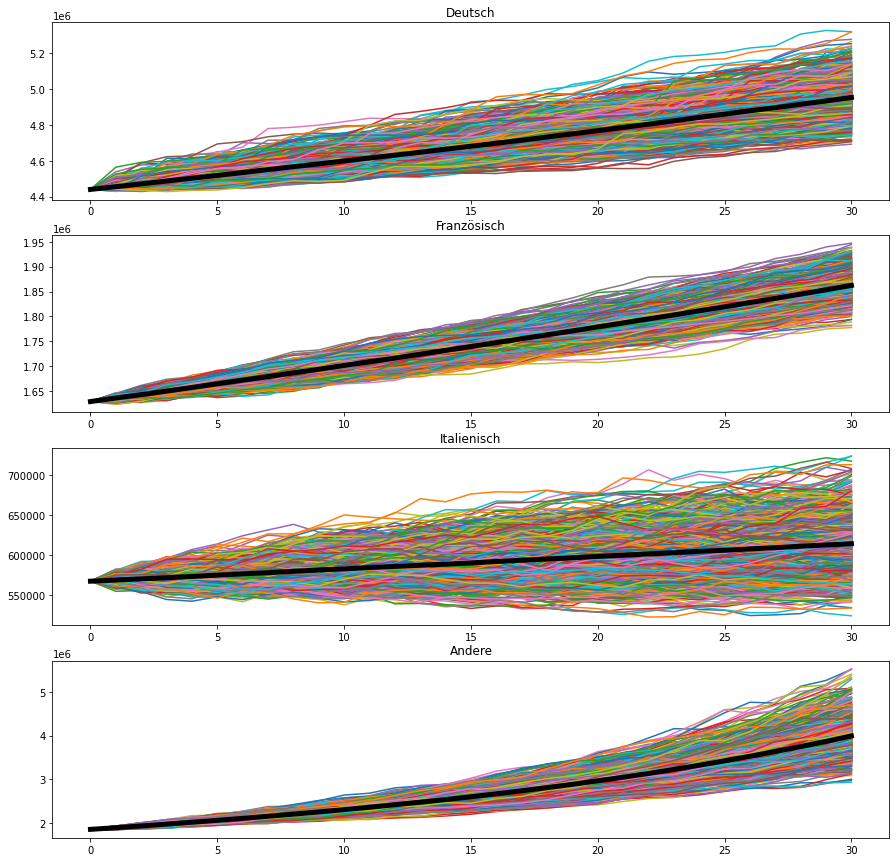

Population end size:  11422721.267429393


In [21]:
def generateDistribution(distr_type_params, pop_start, current_pop, sample_size=10000):
    key = list(distr_type_params.keys())[0]
    params = distr_type_params[key].copy()

    params["scale"] = (params["scale"] / pop_start) * current_pop

    obj = getattr(stats, key)
   
    if type(params) is dict:
        params = list(params.values())

    dist_vals = obj.rvs(size=sample_size, *params)
 
    return dist_vals

def simulation(dist_geburtenRate, dist_todesRaten, dist_einwanderung, dist_auswanderung, startValue,years=50,n=10):
    runs = []
    for i in range(n):
        
        valuesYear = [startValue]
        for year in range(2022,2022+years):
            birthed = random.choice(generateDistribution(dist_geburtenRate, startValue, valuesYear[-1])) / startValue * valuesYear[-1]
            dead = random.choice(generateDistribution(dist_todesRaten, startValue, valuesYear[-1])) / startValue * valuesYear[-1]
            eingewandert = random.choice(generateDistribution(dist_einwanderung, startValue, valuesYear[-1])) / startValue * valuesYear[-1]
            ausgewandert = random.choice(generateDistribution(dist_auswanderung, startValue, valuesYear[-1])) / startValue * valuesYear[-1]

            newValue = valuesYear[-1] + birthed - dead + eingewandert - ausgewandert
            valuesYear.append(newValue)

        runs.append(np.array(valuesYear))

    return np.array(runs)

def MeanOfSim(runs:np.array):
    return runs.mean(axis=0)

n = 1000
years=30
startValues = (4440082, 1628228, 567203, 1850152)

print("Population start size: ", np.sum(startValues))

Deutsch = simulation(geburtenRate["Deutsch"], todesRaten["Deutsch"], einwanderung["Deutsch"], auswanderung["Deutsch"], startValues[0],years=years,n=n)
Französisch = simulation(geburtenRate["Französisch"], todesRaten["Französisch"], einwanderung["Französisch"], auswanderung["Französisch"], startValues[1],years=years,n=n)
Italienisch = simulation(geburtenRate["Italienisch"], todesRaten["Italienisch"], einwanderung["Italienisch"], auswanderung["Italienisch"], startValues[2],years=years,n=n)
Andere = simulation(geburtenRate["Andere"], todesRaten["Andere"], einwanderung["Andere"], auswanderung["Andere"], startValues[3],years=years,n=n)

fig, ax = plt.subplots(4, 1, figsize=(15,15))

#plot Deutsch
for i in range(len(Deutsch)):
    ax[0].plot(Deutsch[i])

ax[0].plot(MeanOfSim(Deutsch), color="black", linewidth=5)

ax[0].set_title("Deutsch")

for i in range(len(Französisch)):
    ax[1].plot(Französisch[i])

ax[1].plot(MeanOfSim(Französisch), color="black", linewidth=5)

ax[1].set_title("Französisch")

for i in range(len(Italienisch)):
    ax[2].plot(Italienisch[i])

ax[2].plot(MeanOfSim(Italienisch), color="black", linewidth=5)

ax[2].set_title("Italienisch")

for i in range(len(Andere)):
    ax[3].plot(Andere[i])

ax[3].plot(MeanOfSim(Andere), color="black", linewidth=5)

ax[3].set_title("Andere")

plt.show()

print("Population end size: ", np.sum([MeanOfSim(Deutsch)[-1], MeanOfSim(Französisch)[-1], MeanOfSim(Italienisch)[-1], MeanOfSim(Andere)[-1]]))

In [22]:
#plot stacked area chart of all languages with plotly
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Deutsch),stackgroup='one',mode='lines', name='Deutsch',groupnorm='percent'))
fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Französisch),stackgroup='one',mode='lines', name='Französisch'))
fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Italienisch),stackgroup='one',mode='lines', name='Italienisch'))
fig.add_trace(go.Scatter(x = np.array(range(0,years)), y = MeanOfSim(Andere),stackgroup='one',mode='lines', name='Andere'))


fig.update_layout(
    showlegend=True,
    xaxis_type='linear',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()
